In [1]:
import torch
import torch.optim as optim
import wandb
from environment import WaterTank
from environment_JAX import WaterTank_Jax
from model import MLP, log_weights_and_derivatives
from plotting import plot_history
import time
import pandas as pd
%load_ext autoreload
%autoreload 2

# Learn

In [2]:
from params import influx_params, env_params, model_params, run_params, start_params, optimizer_params

wandb.init(
    project="Water Tank",
    name="pytorch 1-layer leaky long",
    config={
        "environment": env_params,
        "influx":influx_params,
        "model": model_params,
        "optimizer": optimizer_params,
        "run": run_params,
        "start": start_params
    }
)

seed = 42
torch.manual_seed(seed)

# timer
timer = {
    "epoch": [],
    "step": [],
    "take_step": [],
    "parameter_update": [],
    "log": []
}
total_time = time.time()
def record_time(section_name):
    start_time = time.time()
    timer[section_name].append(start_time)
    
def update_timer(section_name):
    end_time = time.time()
    elapsed_time = end_time - timer[section_name][-1]
    timer[section_name][-1] = elapsed_time


model = MLP(model_params)
# Load the saved parameters
# model.load_state_dict(torch.load('model_params.pth'))

optimizer = optim.Adam(model.parameters(), lr=optimizer_params["learning_rate"])

prev_weights = [param.detach().clone() for param in model.parameters()]

# Training loop
for epoch in range(run_params["num_epochs"]):
    record_time("epoch")
    water_tank = WaterTank(start_params, env_params, influx_params)

    for step in range(run_params["num_steps"]):
        record_time("step")
        record_time("take_step")
        state = water_tank.get_state()

        outflux_percentage = model(state)

        # Take a step in the environment
        reward = water_tank.step(outflux_percentage)
        
        update_timer("take_step")
        record_time("parameter_update")
        
        # Update the MLP using the reward and gradients
        optimizer.zero_grad()
        reward.backward()
        optimizer.step()
        
        update_timer("parameter_update")
        update_timer("step")
    
    record_time("log")
    # Log the episode reward and other relevant information
    log_weights_and_derivatives(model, prev_weights)
    wandb.log(
        {
            "loss": reward.item(),
            "level": water_tank.level.item(),
            "outflux percentage": outflux_percentage.item()
        }
    )
    update_timer("log")
    prev_weights = [param.detach().clone() for param in model.parameters()]
    update_timer("epoch")

# Save the model's parameters to a file
torch.save(model.state_dict(), 'model_params.pth')

wandb.finish()
total_time = time.time() - total_time

wandb: Currently logged in as: martingignatov. Use `wandb login --relogin` to force relogin


level,▄█▁█████████████████████████████████████
loss,▄█▁█████████████████████████████████████
max_abs_gradient,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_abs_weight,▁▁██████████████████████████████████████
max_abs_weight_change,█▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_abs_gradient,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_abs_weight,▁▁██████████████████████████████████████
mean_abs_weight_change,▅▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
outflux percentage,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
level,34.99998
loss,24.99998


# Timer

In [3]:
df1 = pd.DataFrame({key: timer[key] for key in ["log", "epoch"]})
df2 = pd.DataFrame({key: timer[key] for key in timer if key not in ["log", "epoch"]})

print(total_time)
display(df1.describe())
df2.describe()

35.84674549102783


,log,epoch
count,100.000000,100.000000
mean,0.000712,0.299452
std,0.000189,0.015888
min,0.000614,0.278733
25%,0.000651,0.291925
50%,0.000671,0.296533
75%,0.000712,0.301711
max,0.002444,0.395303


,step,take_step,parameter_update
count,50000.000000,50000.000000,50000.000000
mean,0.000597,0.000233,0.000362
std,0.000200,0.000066,0.000139
min,0.000532,0.000203,0.000325
25%,0.000562,0.000215,0.000342
50%,0.000575,0.000223,0.000347
75%,0.000595,0.000229,0.000359
max,0.041502,0.012339,0.029156


# Run One Episode

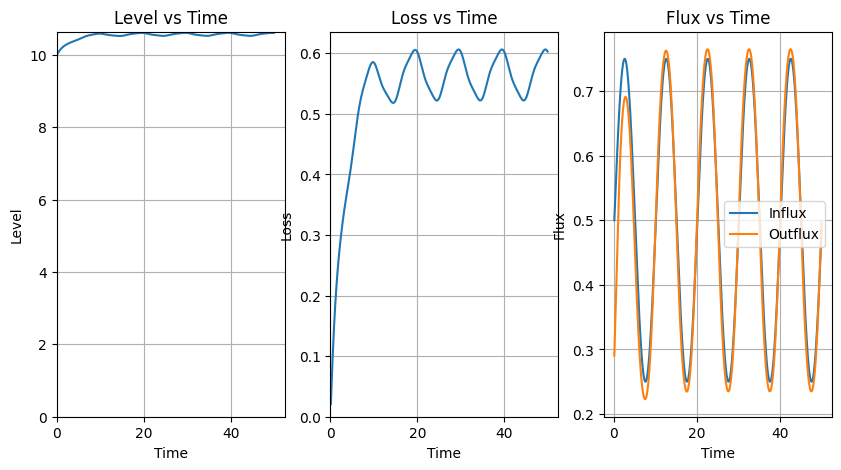

In [4]:
from params import influx_params, env_params, model_params, run_params, start_params, optimizer_params

# Initialize the environment and the MLP
model = MLP(model_params)

# Load the saved parameters
model.load_state_dict(torch.load('model_params.pth'))

water_tank = WaterTank(start_params, env_params, influx_params)

for step in range(run_params["num_steps"]):
    # Prepare the input for the MLP network (current_level and next_step_influx)
    state = water_tank.get_state()

    # Get the outflux_percentage from the MLP
    outflux_percentage = model(state)

    # Take a step in the environment
    reward = water_tank.step(outflux_percentage)

plot_history(*water_tank.get_history())